<a href="https://colab.research.google.com/github/lhovius/UvA_NLP1/blob/main/NLP1_2021_Practical_1_(student_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------
**NLP1 Assignment 1: Elynn Weijland and Linda Hovius (12205184)**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.7.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [1]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [2]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2021-11-06 10:09:04--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.04s   

2021-11-06 10:09:04 (14.4 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2021-11-06 10:09:04--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [3]:
# file structure is a list of dictionaries met 'cv' als indexnummer:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n') # length want het is een list

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [4]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip().split())
    line_cnt += 1
    if line_cnt > 4:
      break

['type=weaksubj', 'len=1', 'word1=abandoned', 'pos1=adj', 'stemmed1=n', 'priorpolarity=negative']
['type=weaksubj', 'len=1', 'word1=abandonment', 'pos1=noun', 'stemmed1=n', 'priorpolarity=negative']
['type=weaksubj', 'len=1', 'word1=abandon', 'pos1=verb', 'stemmed1=y', 'priorpolarity=negative']
['type=strongsubj', 'len=1', 'word1=abase', 'pos1=verb', 'stemmed1=y', 'priorpolarity=negative']
['type=strongsubj', 'len=1', 'word1=abasement', 'pos1=anypos', 'stemmed1=y', 'priorpolarity=negative']


In [5]:
def content_to_text(content):
  text = ''
  for sent in content:
    for combi in sent:
      word = combi[0]
      text = text+' '+word
  return text

In [6]:
reviewsDF = pd.DataFrame(reviews)
reviewsDF['text'] = reviewsDF['content'].apply(content_to_text)
reviewsDF.head()

,cv,sentiment,content,text
0,0,NEG,"[[[Two, CD], [teen, JJ], [couples, NNS], [go, ...","Two teen couples go to a church party , drink..."
1,1,NEG,"[[[Damn, JJ], [that, IN], [Y2K, CD], [bug, NN]...",Damn that Y2K bug . It 's got a head start in...
2,2,NEG,"[[[It, PRP], [is, VBZ], [movies, NNS], [like, ...",It is movies like these that make a jaded mov...
3,3,NEG,"[[[QUEST, NN], [FOR, IN], [CAMELOT, NNP], [``,...",QUEST FOR CAMELOT `` Quest for Camelot '' is ...
4,4,NEG,"[[[Synopsis, NNPS], [:, :], [A, DT], [mentally...",Synopsis : A mentally unstable man undergoing...



Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [8]:
reviewsDF[['sentiment', 'nr_tokens']].groupby('sentiment').describe()
# OVERLEG ELYNN, WAAR KOMT DIE 7.13 VANDAAN? IS DAT HET AANTAL ZINNEN OF ZO? HEB JE NODIG VOOR DE ALTERNATIEVE VARIABELE THRESHOLD!

KeyError: ignored

In [9]:
# Create a lookup dictionary (dictionary is fast because of hashing)
# We will need the weights later on, so we'll add them right away

sent_lex = dict()
weight_lex =dict()
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
#  line_cnt = 0
  for line in f:
    lijst = line.strip().split()
    sent_lex[lijst[2][6:]]=lijst[5][14:]
    if lijst[0][5:10].startswith('str'):
      weight_lex[lijst[2][6:]]=2
    elif lijst[0][5:10].startswith('wea'):
      weight_lex[lijst[2][6:]]=1

for i,s in enumerate(sent_lex):
  print(f'Sentiment lexicon has {len(sent_lex)} entries, starting with: {s}')
  print(f'Weight lexicon has {len(weight_lex)} entries, starting with: {s}')
  if i==0:
    break

Sentiment lexicon has 6886 entries, starting with: abandoned
Weight lexicon has 6886 entries, starting with: abandoned


In [10]:
def create_unweighted_polarity(threshold,text):
  # insert assert dtypes
  polarity=threshold
  for token in text.split():
    t = token.lower()
    if t in sent_lex:
      if sent_lex[t]=='positive':
        polarity+=1
      elif sent_lex[t]=='negative':
        polarity-=1
  return polarity

In [11]:
reviewsDF['unweighted_polarity'] = [create_unweighted_polarity(-8,txt) for txt in reviewsDF['text']]
reviewsDF['unweighted_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['unweighted_polarity']]

In [12]:
# compare y_true with y_predict to calculate prediction accuracy
# we create a list of binary indicators, called token_results, where 1 indicates a correct classification and 0 an incorrect one
token_results = []
for true, predict in zip(reviewsDF['sentiment'],reviewsDF['unweighted_predict']):
  if true==predict:
    token_results.append(1)
  else:
    token_results.append(0)

print(f'Length token_results is {len(token_results)}, first entry is {token_results[0]}')
print(f"Accuracy of unweighted sign-only classification (with fixed threshold): {sum(token_results)/len(token_results)}")

Length token_results is 2000, first entry is 0
Accuracy of unweighted sign-only classification (with fixed threshold): 0.679


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

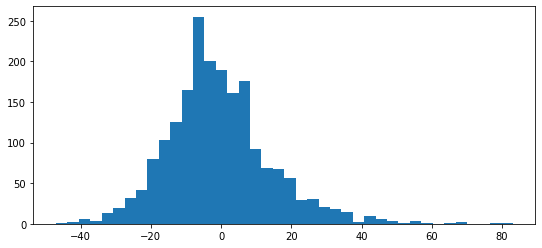

Mean of unweighted polarity (with threshold): -0.806
Standard deviation of unweighted polarity (with threshold): 14.808996049698989


In [13]:
# Before we see what the weights do, let's first take a look at the unweighted distribution of polarity scores
# This will be handy to make a valid comparison between the two distributions later (and set the threshold right)

plt.figure(figsize=(9,4))
plt.hist(reviewsDF['unweighted_polarity'], bins=40)
plt.show()

print(f"Mean of unweighted polarity (with threshold): {np.mean(reviewsDF['unweighted_polarity'])}")
print(f"Standard deviation of unweighted polarity (with threshold): {np.std(reviewsDF['unweighted_polarity'])}")

In [14]:
def create_weighted_polarity(threshold,text):
  # insert assert dtypes
  polarity=threshold
  for token in text.split():
    t = token.lower()
    if t in sent_lex:
      if sent_lex[t]=='positive':
        polarity+=1*weight_lex[t]
      elif sent_lex[t]=='negative':
        polarity-=1*weight_lex[t]
  return polarity

In [15]:
reviewsDF['weighted_polarity'] = [create_weighted_polarity(-8,txt) for txt in reviewsDF['text']]
reviewsDF['weighted_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['weighted_polarity']]

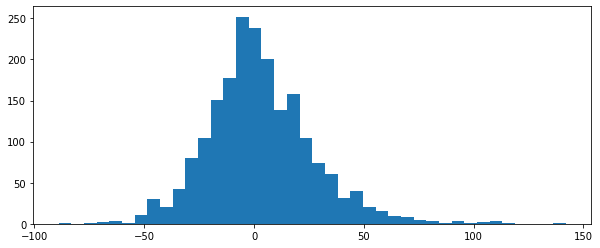

Mean of weighted polarity (with threshold): 2.8195
Standard deviation of weighted polarity (with threshold): 24.316289185441132


In [16]:
# what is the distribution of the weighted polarity scores?
plt.figure(figsize=(10,4))
plt.hist(reviewsDF['weighted_polarity'], bins=40)
plt.show()

print(f"Mean of weighted polarity (with threshold): {np.mean(reviewsDF['weighted_polarity'])}")
print(f"Standard deviation of weighted polarity (with threshold): {np.std(reviewsDF['weighted_polarity'])}")
# The mean went up by 2 points and the std also nearly doubled. This means that we need to tweak the threshold

In [17]:
reviewsDF['weighted_polarity'] = [create_weighted_polarity(-11.5,txt) for txt in reviewsDF['text']]
reviewsDF['weighted_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['weighted_polarity']]
print(f"Mean of weighted polarity (with threshold): {np.mean(reviewsDF['weighted_polarity'])}")
# We tried different thresholds, -11.5 comes close to the unweighted mean

Mean of weighted polarity (with threshold): -0.6805


In [18]:
# compare y_true with y_predict to calculate prediction accuracy
# we create a list of binary indicators, called magnitude_results, where 1 indicates a correct classification and 0 an incorrect one
magnitude_results = []
for true, predict in zip(reviewsDF['sentiment'],reviewsDF['weighted_predict']):
  if true==predict:
    magnitude_results.append(1)
  else:
    magnitude_results.append(0)
print(f'length magnitude_results is {len(magnitude_results)}, first entry is {magnitude_results[0]}')

print(f"Accuracy of weighted sign-only classification (with fixed threshold): {sum(magnitude_results)/len(magnitude_results)}")
# It is a marginal improvement, we went from 0.679 to 0.696

length magnitude_results is 2000, first entry is 0
Accuracy of weighted sign-only classification (with fixed threshold): 0.696


#### (Q.1.4) Make a barplot of the two results (0.5pt)

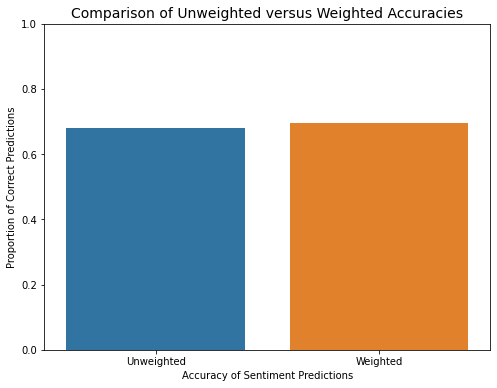

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
y = [sum(token_results)/len(token_results), sum(magnitude_results)/len(magnitude_results)]
x = 'Unweighted Weighted'.split()
sns.barplot(x=x,y=y,ax=ax)
ax.set_xlabel("Accuracy of Sentiment Predictions")
ax.set_ylabel("Proportion of Correct Predictions")
ax.set_title("Comparison of Unweighted versus Weighted Accuracies", fontsize=14)
ax.set_ylim(0,1)
plt.show()

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

Document Length could affect the sentiment of the review in two ways:


1.   Regression to the mean: it is likely that shorter reviews have fewer words from the sentiment lexicon and therefore fewer values to calculate the overall score. In general, when a value is calculated from a small number of values, it tends to digress more from the grand mean than when it is calculated from a large number of values. If this is the case in this dataset, we would see that the highest and the lowest scores on the polarity scales (both weighted and unweighted) would come from the shorter reviews
2.   Answer tendencies: people who are positive might take more time to write their reviews (they are enthusiastic, want to help readers make the right choice, want to help the movie makers get more traffic), whereas dissatisfied people might feel that a simple explanation of why they're negative suffices.



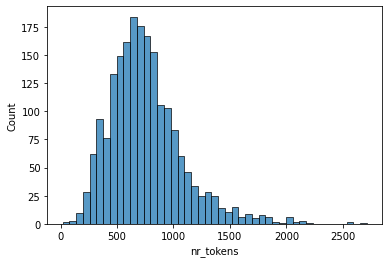

In [20]:
reviewsDF['nr_tokens'] = [len(x) for x in reviewsDF['text'].str.split()]
reviewsDF['length_bin'] = pd.qcut(np.array(reviewsDF['nr_tokens']),5, labels='very_short short medium long very_long'.split())
sns.histplot(reviewsDF['nr_tokens']) # not too skewed, considering it's made of counts; still, we might consider ln-transform if we need it to be Gaussian

In [21]:
corr_length_sent = np.corrcoef(reviewsDF['nr_tokens'], reviewsDF['weighted_polarity'])[0][1]
corr_length_sent

0.24971950935019657

           weighted_polarity                       ...                  
                       count      mean        std  ...  50%   75%    max
length_bin                                         ...                  
very_short             403.0 -7.142680  15.224730  ... -7.5   2.0   42.5
short                  400.0 -3.882500  18.094744  ... -4.0   8.5   51.5
medium                 397.0 -2.031486  21.431053  ... -3.5  12.5   65.5
long                   400.0  0.015000  24.323319  ... -1.5  14.5   87.5
very_long              400.0  9.677500  34.541116  ...  8.5  33.5  138.5

[5 rows x 8 columns]


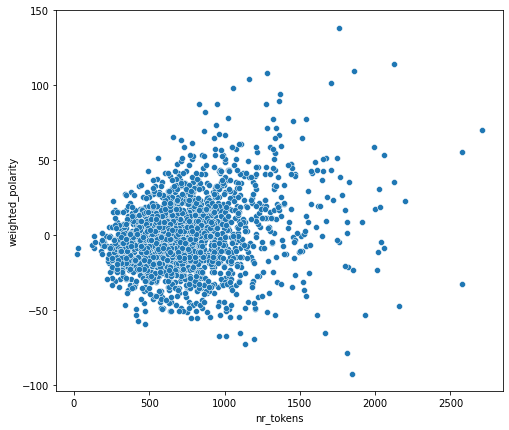

In [22]:
weight_per_group = reviewsDF[['length_bin','weighted_polarity']].groupby('length_bin')
print(weight_per_group.describe()) # we see an increase in both mean and std, because the lowest minimum is found in the highest group.
# The 'regression to the mean' explanation seems invalid; the shorter the text, the less it deviates from its (in general negative) sentiment
# Rather, it seems that - although the longer texts tend to be the most positive - the really annoyed reviewers tend to write long stories too

plt.figure(figsize=(8,7))
sns.scatterplot(x=reviewsDF['nr_tokens'], y=reviewsDF['weighted_polarity'])
plt.show()

In [23]:
"""
Given that there seems to be a somewhat linear relationship between positivity and review length, 
we decided to create a simple Linear Regression between these two to use as threshold.
This way, the threshold for each review's polarity will be based on its review length, 
as measured by the number of tokens in its review.
"""

Beta_1 = corr_length_sent*(np.std(reviewsDF['weighted_polarity'])/np.std(reviewsDF['nr_tokens']))
Beta_0 = reviewsDF['weighted_polarity'].mean()- reviewsDF['nr_tokens'].mean()*Beta_1
print(f"Linear Regression line: Threshold = {round(Beta_0,2)} + {round(Beta_1,3)} * nr_tokens")

Linear Regression line: Threshold = -14.51 + 0.018 * nr_tokens


In [24]:
def create_varthreshold_polarity(nr_tokens,text, Beta_0=Beta_0):
  # insert assert dtypes
  threshold = Beta_0+Beta_1*nr_tokens
  polarity=threshold
  for token in text.split():
    t = token.lower()
    if t in sent_lex:
      if sent_lex[t]=='positive':
        polarity+=1*weight_lex[t]
      elif sent_lex[t]=='negative':
        polarity-=1*weight_lex[t]
  return polarity

Mean of weighted polarity (with length-based threshold): 10.14


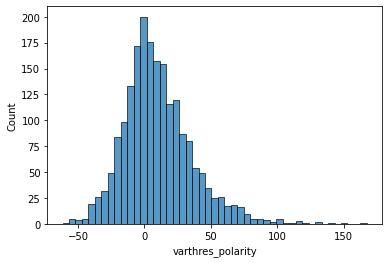

In [25]:
reviewsDF['varthres_polarity'] = reviewsDF.apply(lambda row: create_varthreshold_polarity(row.nr_tokens,row.text), axis=1)
reviewsDF['varthres_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['varthres_polarity']]
print(f"Mean of weighted polarity (with length-based threshold): {round(reviewsDF['varthres_polarity'].mean(),2)}")
sns.histplot(reviewsDF['varthres_polarity'])
plt.show()

# Oumph, the mean is now much higher - do we need to correct this?

In [26]:
# compare y_true with y_predict to calculate prediction accuracy
# we create a list of binary indicators, called threshold_results, where 1 indicates a correct classification and 0 an incorrect one
threshold_results = []
for true, predict in zip(reviewsDF['sentiment'],reviewsDF['varthres_predict']):
  if true==predict:
    threshold_results.append(1)
  else:
    threshold_results.append(0)
print(f'length threshold_results is {len(threshold_results)}, first entry is {threshold_results[0]}')

print(f"Accuracy of weighted sign-only classification (with fixed threshold): {sum(threshold_results)/len(threshold_results)}")
# It is worse now, possibly because the mean is too high

length threshold_results is 2000, first entry is 0
Accuracy of weighted sign-only classification (with fixed threshold): 0.654


Mean of weighted polarity (with length-based threshold): -0.0


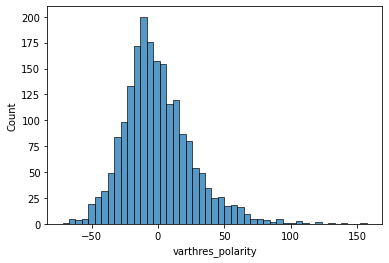

In [27]:
# Make another one with a lower Beta_0, just to get the mean back to 0:
reviewsDF['varthres_polarity'] = reviewsDF.apply(lambda row: create_varthreshold_polarity(row.nr_tokens,row.text,Beta_0-10.14), axis=1)
reviewsDF['varthres_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['varthres_polarity']]
print(f"Mean of weighted polarity (with length-based threshold): {round(reviewsDF['varthres_polarity'].mean(),2)}")
sns.histplot(reviewsDF['varthres_polarity'])
plt.show()

# Now the mean is 0

In [28]:
# compare y_true with y_predict to calculate prediction accuracy
# we create a list of binary indicators, called threshold_results, where 1 indicates a correct classification and 0 an incorrect one
threshold_results = []
for true, predict in zip(reviewsDF['sentiment'],reviewsDF['varthres_predict']):
  if true==predict:
    threshold_results.append(1)
  else:
    threshold_results.append(0)
print(f'length threshold_results is {len(threshold_results)}, first entry is {threshold_results[0]}')

print(f"Accuracy of weighted sign-only classification (with fixed threshold): {sum(threshold_results)/len(threshold_results)}")
# Better than the regular Beta_0 but not an improvement over the previous two

length threshold_results is 2000, first entry is 0
Accuracy of weighted sign-only classification (with fixed threshold): 0.6805


In [29]:
# Alternative approach: calculate the average threshold per token:
thresh_per_word = 11.5/ reviewsDF['nr_tokens'].mean()

def create_varthreshold_polarity2(nr_tokens,text):
  threshold = - thresh_per_word*nr_tokens
  polarity=threshold
  for token in text.split():
    t = token.lower()
    if t in sent_lex:
      if sent_lex[t]=='positive':
        polarity+=1*weight_lex[t]
      elif sent_lex[t]=='negative':
        polarity-=1*weight_lex[t]
  return polarity

Mean of weighted polarity (with length-based threshold): -0.68


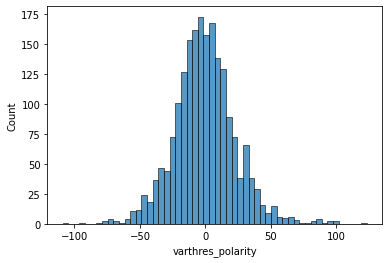

In [30]:
reviewsDF['varthres_polarity'] = reviewsDF.apply(lambda row: create_varthreshold_polarity2(row.nr_tokens,row.text), axis=1)
reviewsDF['varthres_predict'] = ['POS' if x>=0 else 'NEG' for x in reviewsDF['varthres_polarity']]
print(f"Mean of weighted polarity (with length-based threshold): {round(reviewsDF['varthres_polarity'].mean(),2)}")
sns.histplot(reviewsDF['varthres_polarity'])
plt.show()

In [31]:
# compare y_true with y_predict to calculate prediction accuracy
# we create a list of binary indicators, called threshold_results, where 1 indicates a correct classification and 0 an incorrect one
threshold_results = []
for true, predict in zip(reviewsDF['sentiment'],reviewsDF['varthres_predict']):
  if true==predict:
    threshold_results.append(1)
  else:
    threshold_results.append(0)
print(f'length threshold_results is {len(threshold_results)}, first entry is {threshold_results[0]}')
print(f"Accuracy of weighted sign-only classification (with fixed threshold): {sum(threshold_results)/len(threshold_results)}")
# Slight improvement

length threshold_results is 2000, first entry is 0
Accuracy of weighted sign-only classification (with fixed threshold): 0.6945


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

*Write your answer here.*

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [32]:
# YOUR CODE HERE
train = reviewsDF[reviewsDF['cv']<=899][['cv', 'sentiment', 'text', 'nr_tokens', 'length_bin']]
test = reviewsDF[(reviewsDF['cv']>=900)&(reviewsDF['cv']<=999)][['cv', 'sentiment', 'text', 'nr_tokens', 'length_bin']]
print(f"length training set: {len(train)}, with {len(train[train['sentiment']=='POS'])} Positive reviews")
print(f"length test set: {len(test)}, with {len(test[test['sentiment']=='POS'])} Positive reviews")
# Both are balanced

length training set: 1800, with 900 Positive reviews
length test set: 200, with 100 Positive reviews


In [33]:
# manual version of the above:
"""
We start with creating a full vocab of all tokens in the training set, with frequency set at 1,
in order to:
- prevent 0 counts in a class (which will always lead to 0 probabilites for this class, no matter the evidence)
- enable comparisons over classes, giving them the same vocab size

Next, we create two frequency dictionaries, one for words in the positive reviews, one for the negative ones.

Finally, we create two probability dictionaries, that have these counts normalized and transformed to log likelihoods
"""
# step 1: instantiate two count dictionaries with all word counts set to 1
alltext = {t.lower() for t in ' '.join(train['text']).split()}
lookup_POS = {t:1 for t in alltext}
lookup_NEG = {t:1 for t in alltext}

# step 2: fill the two dictionaries with the actual word counts from the texts in their class:
postexts = ''.join(train[train['sentiment']=='POS']['text']).split()
for t in postexts:
  token=t.lower()
  lookup_POS[token] += 1
negtexts = ''.join(train[train['sentiment']=='NEG']['text']).split()
for t in negtexts:
  token=t.lower()
  lookup_NEG[token] += 1

# step 3: create two new dictionaries with the normalized log-likelihoods of these counts per class:
lookup_POSprob = dict()
lookup_NEGprob = dict()
for word in lookup_POS:
  lookup_POSprob[word] = np.log( lookup_POS[word] / (len(postexts)+len(alltext)) )
for word in lookup_NEG:
  lookup_NEGprob[word] = np.log( lookup_NEG[word] / (len(negtexts)+len(alltext)) )  

prior_POS = len(train[train['sentiment']=='POS']) / len(train)
prior_NEG = len(train[train['sentiment']=='NEG']) / len(train)

In [34]:
# create a function to calculate log-likelihoods. We use the natural logarithm for this:
def calculate_class_prob(text, lookup_POSprob=lookup_POSprob, lookup_NEGprob=lookup_NEGprob):
  """
  This function takes as input: 
  - raw text in string format
  - two lookup dictionaries (one for each class) with normalized log probabilites for each word

  The function calculates the total log likelihood of a text belonging to one of these two classes,
  based on Naive Bayes. It returns a POS or NEG class prediction.
  """
  prob_pos = 0
  prob_neg = 0
  for token in text.split():
    t=token.lower()
    if t in alltext:
      prob_pos += lookup_POSprob[t]
      prob_neg += lookup_NEGprob[t]
  if prob_pos*prior_POS > prob_neg*prior_NEG:
    return 'POS'
  else:
    return 'NEG'
  # return prob_pos*prior_POS,prob_neg*prior_NEG

In [35]:
test['predict_NB'] = test['text'].apply(calculate_class_prob)
test.groupby('predict_NB').describe()

cv                                ... nr_tokens                      
            count        mean        std    min  ...       25%    50%    75%     max
predict_NB                                       ...                                
NEG         107.0  950.018692  29.188387  900.0  ...     555.0  673.0  883.5  1797.0
POS          93.0  948.903226  28.794649  900.0  ...     568.0  758.0  983.0  2030.0

[2 rows x 16 columns]

In [36]:
# Measure accuracy
test_results = []
for true, predict in zip(test['sentiment'],test['predict_NB']):
  if true==predict:
    test_results.append(1)
  else:
    test_results.append(0)
print(f'length test_results is {len(test_results)}, first entry is {test_results[0]}')

print(f"Accuracy of Naive Bayes classification: {sum(test_results)/len(test_results)}")
# Quite the improvement

length test_results is 200, first entry is 1
Accuracy of Naive Bayes classification (without Smoothing): 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

*Write your answer here.*
We see below that the classifier learns to classify everything as positive, because that already gives an accuracy of 90% (because 90% of the data in both the training and test set is now positive). 

In [66]:
# YOUR CODE HERE
train2 = train[ ((train.sentiment=='NEG') & (train['cv']<=89)) | (train.sentiment=='POS') ].copy()
print(f"length of train2: {len(train2)}, with {len(train2[train2.sentiment=='POS'])} positive and {len(train2[train2.sentiment=='NEG'])} negative reviews")
test2 = test[ ((test.sentiment=='NEG') & (test.cv<=909)) | (test.sentiment=='POS') ].copy()
print(f"length of test2: {len(test2)}, with {len(test2[test2.sentiment=='POS'])} positive and {len(test2[test2.sentiment=='NEG'])} negative reviews")

length of train2: 990, with 900 positive and 90 negative reviews
length of test2: 110, with 100 positive and 10 negative reviews


In [67]:
# manual version of the above:
"""
We start with creating a full vocab of all tokens in the training set, with frequency set at 1,
in order to:
- prevent 0 counts in a class (which will always lead to 0 probabilites for this class, no matter the evidence)
- enable comparisons over classes, giving them the same vocab size

Next, we create two frequency dictionaries, one for words in the positive reviews, one for the negative ones.

Finally, we create two probability dictionaries, that have these counts normalized and transformed to log likelihoods
"""
# step 1: instantiate two count dictionaries with all word counts set to 1
alltext = {t.lower() for t in ' '.join(train2['text']).split()}
lookup_POS = {t:1 for t in alltext}
lookup_NEG = {t:1 for t in alltext}

# step 2: fill the two dictionaries with the actual word counts from the texts in their class:
postexts = ''.join(train2[train2['sentiment']=='POS']['text']).split()
for t in postexts:
  token=t.lower()
  lookup_POS[token] += 1
negtexts = ''.join(train2[train2['sentiment']=='NEG']['text']).split()
for t in negtexts:
  token=t.lower()
  lookup_NEG[token] += 1

# step 3: create two new dictionaries with the normalized log-likelihoods of these counts per class:
lookup_POSprob = dict()
lookup_NEGprob = dict()
for word in lookup_POS:
  lookup_POSprob[word] = np.log( lookup_POS[word] / (len(postexts)+len(alltext)) )
for word in lookup_NEG:
  lookup_NEGprob[word] = np.log( lookup_NEG[word] / (len(negtexts)+len(alltext)) )  

In [68]:
test2['predict_NB'] = test2['text'].apply(calculate_class_prob)
test2.groupby('predict_NB').describe()
# As expected, it assumes everything is now positive, it no discerns negative from positive

KeyError: ignored

In [40]:
# Measure accuracy
test_results = []
for true, predict in zip(test2['sentiment'],test2['predict_NB']):
  if true==predict:
    test_results.append(1)
  else:
    test_results.append(0)
print(f'length test_results is {len(test_results)}, first entry is {test_results[0]}')

print(f"Accuracy of Naive Bayes classification (without Smoothing): {sum(test_results)/len(test_results)}")

length test_results is 110, first entry is 1
Accuracy of Naive Bayes classification (without Smoothing): 0.8181818181818182


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [ ]:
# YOUR CODE HERE

# OVERLEG ELYNN, VOLGENS MIJ HEB IK HEM GELIJK AL SMOOTHED GEMAAKT TOCH? ALS ZIJ DE UNSMOOTHED HEEFT, KUNNEN WE GEWOON COMBINEREN

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [64]:
def calculate_class_prob(text, lookup_POSprob=lookup_POSprob, lookup_NEGprob=lookup_NEGprob):
  """
  This function takes as input: 
  - raw text in string format
  - two lookup dictionaries (one for each class) with normalized log probabilites for each word

  The function calculates the total log likelihood of a text belonging to one of these two classes,
  based on Naive Bayes. It returns a POS or NEG class prediction.
  """
  prob_pos = 0
  prob_neg = 0
  for token in text.split():
    t=token.lower()
    if t in alltext:
      prob_pos += lookup_POSprob[t]
      prob_neg += lookup_NEGprob[t]
  if prob_pos*prior_POS > prob_neg*prior_NEG:
    return 'POS'
  else:
    return 'NEG'

In [73]:
# YOUR CODE HERE
accuracy_results = []

for i in range(10):
  train_val = train[i::10].copy()
  train_train = train[~train.isin(train_val)].dropna()

  # step 1: instantiate two count dictionaries with all word counts set to 1
  alltext = {t.lower() for t in ' '.join(train_train['text']).split()}
  lookup_POS = {t:1 for t in alltext}
  lookup_NEG = {t:1 for t in alltext}
  # step 2: fill the two dictionaries with the actual word counts from the texts in their class:
  postexts = ''.join(train_train[train_train['sentiment']=='POS']['text']).split()
  for t in postexts:
    token=t.lower()
    lookup_POS[token] += 1
  negtexts = ''.join(train_train[train_train['sentiment']=='NEG']['text']).split()
  for t in negtexts:
    token=t.lower()
    lookup_NEG[token] += 1
  # step 3: create two new dictionaries with the normalized log-likelihoods of these counts per class:
  lookup_POSprob = dict()
  lookup_NEGprob = dict()
  for word in lookup_POS:
    lookup_POSprob[word] = np.log( lookup_POS[word] / (len(postexts)+len(alltext)) )
  for word in lookup_NEG:
    lookup_NEGprob[word] = np.log( lookup_NEG[word] / (len(negtexts)+len(alltext)) )  
  prior_POS = len(train_train[train_train['sentiment']=='POS']) / len(train_train)
  prior_NEG = len(train_train[train_train['sentiment']=='NEG']) / len(train_train) 
  # get accuracy score for this fold:
  train_val['predict_NB'] = train_val['text'].apply(calculate_class_prob)
  validation_results = []
  for true, predict in zip(train_val['sentiment'],train_val['predict_NB']):
    if true==predict:
      validation_results.append(1)
    else:
      validation_results.append(0)
  accuracy=sum(validation_results)/len(validation_results)
  accuracy_results.append(accuracy)
  print(f"Accuracy of Naive Bayes classification (fold {i}): {sum(validation_results)/len(validation_results)}")

Accuracy of Naive Bayes classification (fold 0): 0.7722222222222223
Accuracy of Naive Bayes classification (fold 1): 0.9888888888888889
Accuracy of Naive Bayes classification (fold 2): 0.9666666666666667
Accuracy of Naive Bayes classification (fold 3): 0.9611111111111111
Accuracy of Naive Bayes classification (fold 4): 0.9611111111111111
Accuracy of Naive Bayes classification (fold 5): 0.9611111111111111
Accuracy of Naive Bayes classification (fold 6): 0.9666666666666667
Accuracy of Naive Bayes classification (fold 7): 0.9555555555555556
Accuracy of Naive Bayes classification (fold 8): 0.9722222222222222
Accuracy of Naive Bayes classification (fold 9): 0.9666666666666667


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [93]:
# YOUR CODE HERE
print(f"mean of 10-fold NB with smoothing: {np.mean(accuracy_results):.3f}, variance: {np.var(accuracy_results):.4f}")
print(f"number of tokens in the last held-out training set: {len(all_text)}")

mean of 10-fold NB with smoothing: 0.935, variance: 0.0035311728395061746


NameError: ignored

## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [80]:
# YOUR CODE HERE
from nltk.stem.porter import *
stemmer = PorterStemmer()

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [91]:
def calculate_class_prob(text, lookup_POSprob=lookup_POSprob, lookup_NEGprob=lookup_NEGprob):
  """
  This function takes as input: 
  - raw text in string format
  - two lookup dictionaries (one for each class) with normalized log probabilites for each word

  The function calculates the total log likelihood of a text belonging to one of these two classes,
  based on Naive Bayes. It returns a POS or NEG class prediction.
  """
  prob_pos = 0
  prob_neg = 0
  for token in text.split():
    t=stemmer.stem(token.lower())
    if t in alltext:
      prob_pos += lookup_POSprob[t]
      prob_neg += lookup_NEGprob[t]
  if prob_pos*prior_POS > prob_neg*prior_NEG:
    return 'POS'
  else:
    return 'NEG'

In [92]:
# YOUR ANSWER HERE

accuracy_results = []

for i in range(10):
  train_val = train[i::10].copy()
  train_train = train[~train.isin(train_val)].dropna()

  # step 1: instantiate two count dictionaries with all word counts set to 1
  alltext = {stemmer.stem(t.lower()) for t in ' '.join(train_train['text']).split()}
  lookup_POS = {t:1 for t in alltext}
  lookup_NEG = {t:1 for t in alltext}
  # step 2: fill the two dictionaries with the actual word counts from the texts in their class:
  postexts = ''.join(train_train[train_train['sentiment']=='POS']['text']).split()
  for t in postexts:
    token=stemmer.stem(t.lower())
    lookup_POS[token] += 1
  negtexts = ''.join(train_train[train_train['sentiment']=='NEG']['text']).split()
  for t in negtexts:
    token=stemmer.stem(t.lower())
    lookup_NEG[token] += 1
  # step 3: create two new dictionaries with the normalized log-likelihoods of these counts per class:
  lookup_POSprob = dict()
  lookup_NEGprob = dict()
  for word in lookup_POS:
    lookup_POSprob[word] = np.log( lookup_POS[word] / (len(postexts)+len(alltext)) )
  for word in lookup_NEG:
    lookup_NEGprob[word] = np.log( lookup_NEG[word] / (len(negtexts)+len(alltext)) )  
  prior_POS = len(train_train[train_train['sentiment']=='POS']) / len(train_train)
  prior_NEG = len(train_train[train_train['sentiment']=='NEG']) / len(train_train) 
  
  # get accuracy score for this fold:
  train_val['predict_NB'] = train_val['text'].apply(calculate_class_prob)
  validation_results = []
  for true, predict in zip(train_val['sentiment'],train_val['predict_NB']):
    if true==predict:
      validation_results.append(1)
    else:
      validation_results.append(0)
  accuracy=sum(validation_results)/len(validation_results)
  accuracy_results.append(accuracy)
  print(f"Accuracy of Naive Bayes with Porter Stemmer (fold {i}): {sum(validation_results)/len(validation_results)}")

Accuracy of Naive Bayes with Porter Stemmer (fold 0): 0.7611111111111111
Accuracy of Naive Bayes with Porter Stemmer (fold 1): 0.9666666666666667
Accuracy of Naive Bayes with Porter Stemmer (fold 2): 0.9388888888888889
Accuracy of Naive Bayes with Porter Stemmer (fold 3): 0.9666666666666667
Accuracy of Naive Bayes with Porter Stemmer (fold 4): 0.9444444444444444
Accuracy of Naive Bayes with Porter Stemmer (fold 5): 0.9611111111111111
Accuracy of Naive Bayes with Porter Stemmer (fold 6): 0.9666666666666667
Accuracy of Naive Bayes with Porter Stemmer (fold 7): 0.9277777777777778
Accuracy of Naive Bayes with Porter Stemmer (fold 8): 0.9666666666666667
Accuracy of Naive Bayes with Porter Stemmer (fold 9): 0.95


In [98]:
# YOUR CODE HERE
print(f"mean of 10-fold NB with Porter Stemmer: {np.mean(accuracy_results):.3f}, variance: {np.var(accuracy_results):.4f}")
print(f"number of tokens in the last held-out training set: {len(alltext)}")

mean of 10-fold NB with Porter Stemmer: 0.935, variance: 0.0035
number of tokens in the last held-out training set: 30922


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# YOUR CODE HERE
print(f"Number of different tokens in the last held-out training set with Porter stemmer: {len(alltext)}")
#print(f"number of different tokens in the last held-out training set without Porter stemmer: {len(alltext)}")

### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
# YOUR CODE HERE



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Write your answer here.*

In [ ]:
# YOUR CODE HERE

# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE

*Write your answer here.*

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# YOUR CODE HERE

*Write your answer here.*

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission 


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 